# Evaluation of 5-digits CPV classifier based on similarity between notices
## Load dataset
Data are coming as output of 20231107-closest_notices_from_history.ipynb

In [1]:
import json
with open('20231108-predict_cpv_closest_20_with_scores_train_80.json', 'r') as f:
    full_predictions = json.load(f)

In [2]:
print(full_predictions[0])

[{'pred': ['66000000'], 'score': 0.6569411158561707}, {'pred': ['66523100', '66520000', '66522000'], 'score': 0.6087358593940735}, {'pred': ['79410000', '79430000'], 'score': 0.5991131663322449}, {'pred': ['79411000'], 'score': 0.5982860326766968}, {'pred': ['72000000'], 'score': 0.5880882143974304}, {'pred': ['48300000'], 'score': 0.5859005451202393}, {'pred': ['75320000'], 'score': 0.5770848989486694}, {'pred': ['48410000'], 'score': 0.5765272378921509}, {'pred': ['90500000', '63121100', '63121000', '90512000', '90514000', '90513000', '75130000', '63120000', '90510000', '63122000', '90513300', '75131000', '60100000'], 'score': 0.5551028847694397}, {'pred': ['45000000', '45210000'], 'score': 0.5546371936798096}, {'pred': ['45000000', '45210000'], 'score': 0.5546371936798096}, {'pred': ['85000000'], 'score': 0.5539848804473877}, {'pred': ['85000000'], 'score': 0.5526933670043945}, {'pred': ['75211000'], 'score': 0.551079511642456}, {'pred': ['72510000'], 'score': 0.5497228503227234}, {

## Format CPVs to only keep requested numbers of digits

In [3]:
def extract_cpvs_from_full_cpv(local_cpvs, number_digits):
    divisions = []
    local_cpvs = [str(local_cpv) for local_cpv in local_cpvs]
    for local_cpv in local_cpvs:
        if len(local_cpv) < 7:
           continue
        if len(local_cpv) == 7:
            local_cpv = "0"+local_cpv
        for upper_class in range(2, number_digits+1):
            division = local_cpv[:upper_class]
            length_division = len(division)
            if length_division < number_digits:
                remaining_digits = number_digits - length_division
                division = division + "0"*remaining_digits
            if division not in divisions:
                divisions.append(division)
    return divisions


In [4]:
NUMBER_DIGITS_CPV = 5

for element in full_predictions:
    local_cpvs = []
    for sub_element in element:
        if 'pred' in sub_element.keys():
            reduced_cpvs = extract_cpvs_from_full_cpv(sub_element['pred'], NUMBER_DIGITS_CPV)
            sub_element['pred'] = reduced_cpvs
        else:
            reduced_cpvs = extract_cpvs_from_full_cpv(sub_element['actual_cpvs'], NUMBER_DIGITS_CPV)
            sub_element['actual_cpvs'] = reduced_cpvs
print(full_predictions[0])

[{'pred': ['66000'], 'score': 0.6569411158561707}, {'pred': ['66000', '66500', '66520', '66523', '66522'], 'score': 0.6087358593940735}, {'pred': ['79000', '79400', '79410', '79430'], 'score': 0.5991131663322449}, {'pred': ['79000', '79400', '79410', '79411'], 'score': 0.5982860326766968}, {'pred': ['72000'], 'score': 0.5880882143974304}, {'pred': ['48000', '48300'], 'score': 0.5859005451202393}, {'pred': ['75000', '75300', '75320'], 'score': 0.5770848989486694}, {'pred': ['48000', '48400', '48410'], 'score': 0.5765272378921509}, {'pred': ['90000', '90500', '63000', '63100', '63120', '63121', '90510', '90512', '90514', '90513', '75000', '75100', '75130', '63122', '75131', '60000', '60100'], 'score': 0.5551028847694397}, {'pred': ['45000', '45200', '45210'], 'score': 0.5546371936798096}, {'pred': ['45000', '45200', '45210'], 'score': 0.5546371936798096}, {'pred': ['85000'], 'score': 0.5539848804473877}, {'pred': ['85000'], 'score': 0.5526933670043945}, {'pred': ['75000', '75200', '75210

In [5]:
ALL_REDUCED_CPVS = []

for element in full_predictions:
    local_cpvs = []
    for sub_element in element:
        if 'pred' in sub_element.keys():
            pred_values = sub_element['pred']
            local_cpvs.extend(pred_values)
        else:
            actual_values = sub_element['actual_cpvs']
            local_cpvs.extend(actual_values)
    ALL_REDUCED_CPVS.extend(local_cpvs)
    ALL_REDUCED_CPVS = list(set(ALL_REDUCED_CPVS))
    
print(len(ALL_REDUCED_CPVS))


3560


Function to plot metrics

In [6]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt


def calculate_metrics_and_plot(y_true, y_pred):
    thresholds = np.arange(0.1, 1.0, 0.05) 
    precision_scores = []
    recall_scores = []
    f1_scores = []
    best_f1_micro = 0.0
    best_threshold = 0.0

    for threshold in thresholds:
        binary_predictions = (y_pred >= threshold).astype(int)
        precision = precision_score(y_true, binary_predictions, average='micro')
        recall = recall_score(y_true, binary_predictions, average='micro')
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        if f1 > best_f1_micro:
            best_f1_micro = f1
            best_threshold = threshold

    print(f"Best F1 Micro Score: {best_f1_micro:.2f} (Threshold: {best_threshold:.2f})")

    # Plot the micro precision as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision_scores, marker='o', linestyle='-', label='Micro Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Micro Precision')
    plt.title('Micro Precision vs. Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the micro recall as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, recall_scores, marker='o', linestyle='-', label='Micro Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Micro Recall')
    plt.title('Micro Recall vs. Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the F1 micro score as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, marker='o', linestyle='-', label='F1 Micro Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Micro Score')
    plt.title('F1 Micro Score vs. Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(recall_scores, precision_scores, marker='o', linestyle='-', label='Precision-Recall Curve')
    plt.xlabel('Micro Recall')
    plt.ylabel('Micro Precision')
    plt.title('Micro Precision-Recall Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

## Evaluation Method 1

Best F1 Micro Score: 0.51 (Threshold: 0.15)


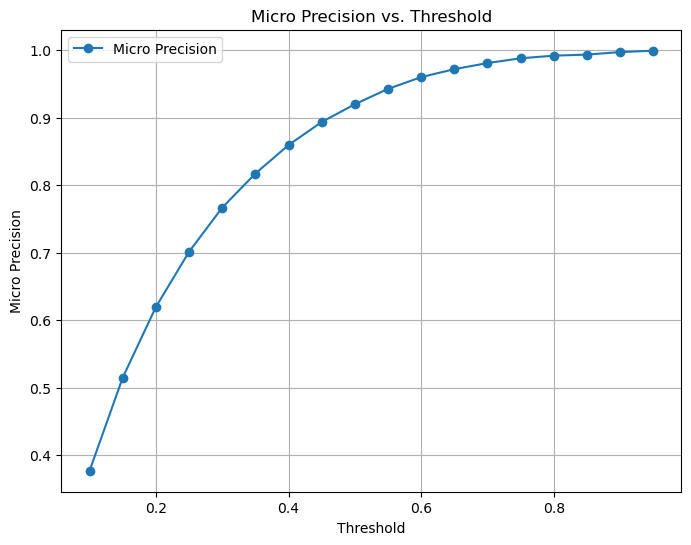

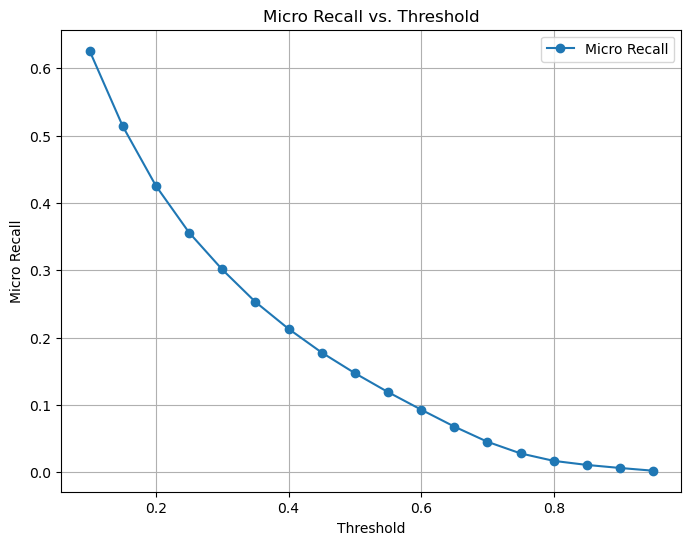

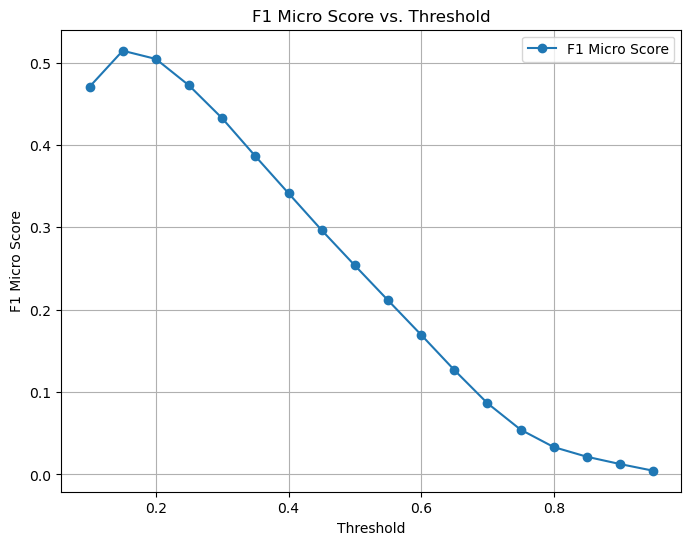

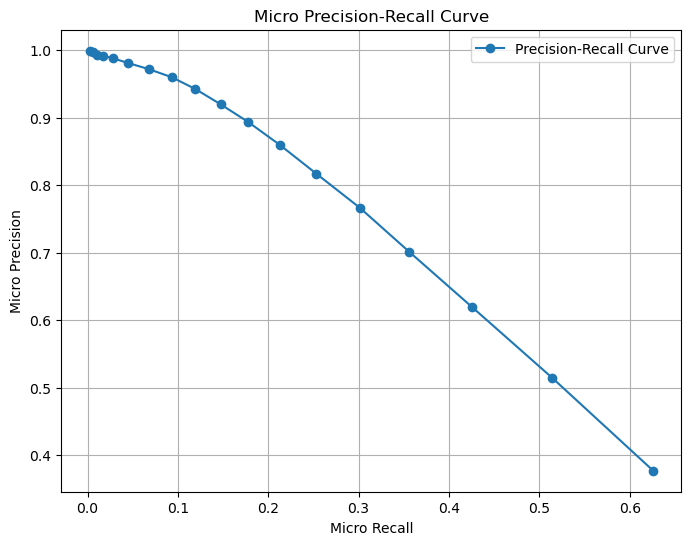

In [7]:
formatted_result_actual = []
formatted_result_pred = []

for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + score_pred
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/length_number_pred
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)
calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 2

Best F1 Micro Score: 0.67 (Threshold: 0.25)


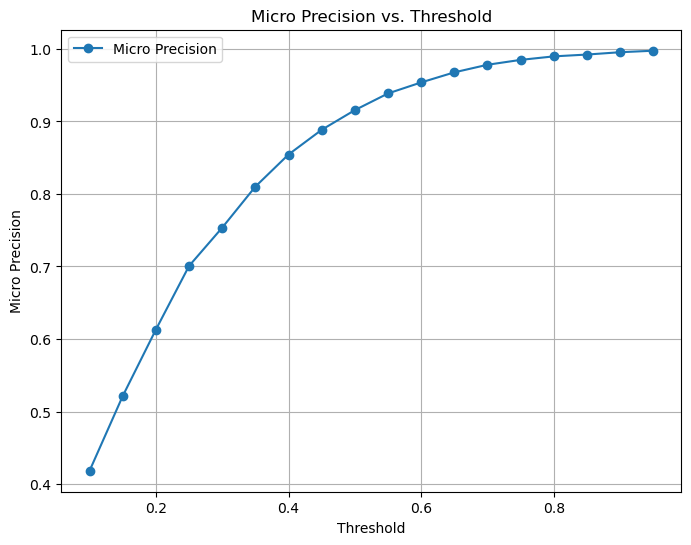

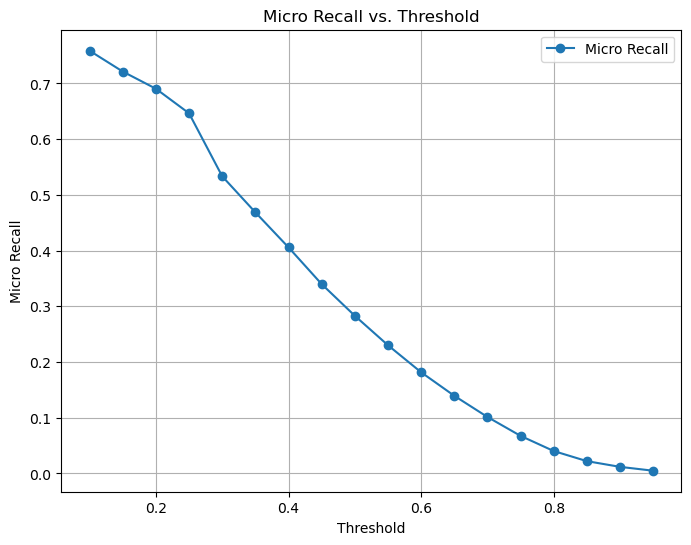

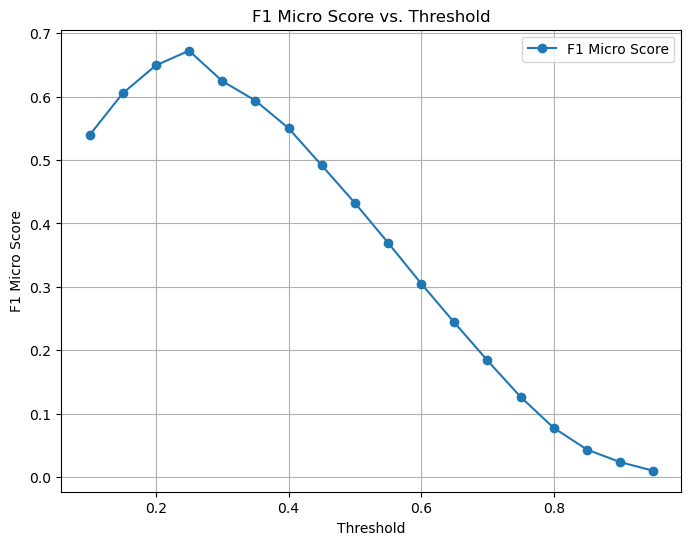

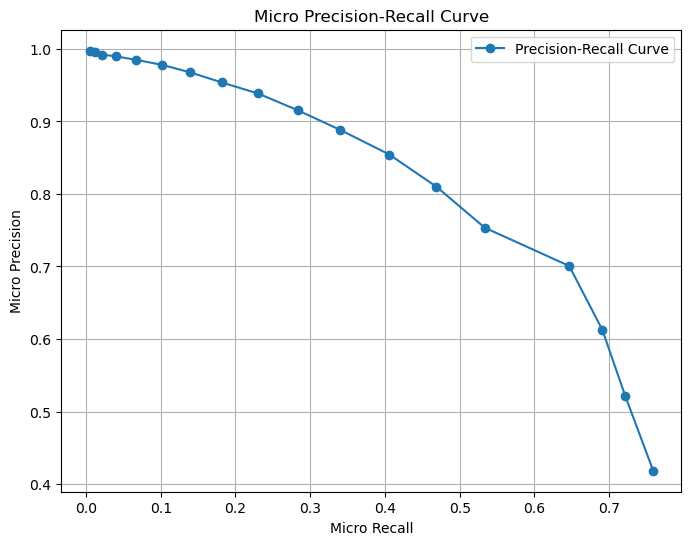

In [8]:
formatted_result_actual = []
formatted_result_pred = []
normalized_factor = 0
for i in range(1, 21):
    normalized_factor += 1/i
    
for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    position = 0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            position += 1
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred / position
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + (score_pred / position)
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/normalized_factor
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)
calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 3

Best F1 Micro Score: 0.62 (Threshold: 0.25)


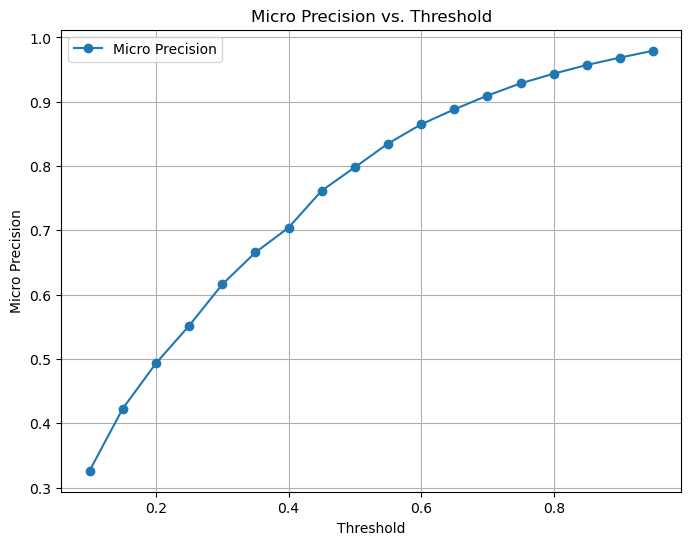

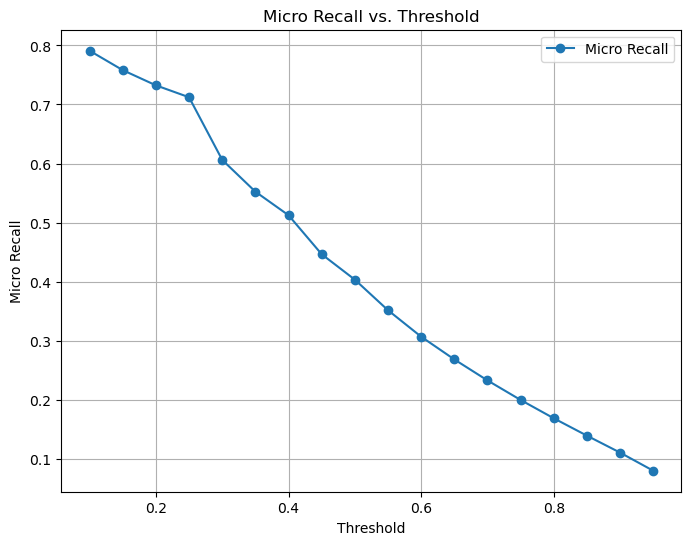

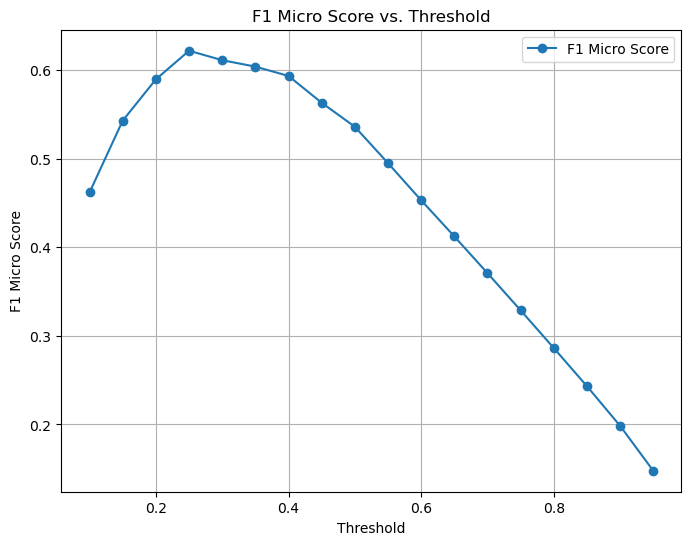

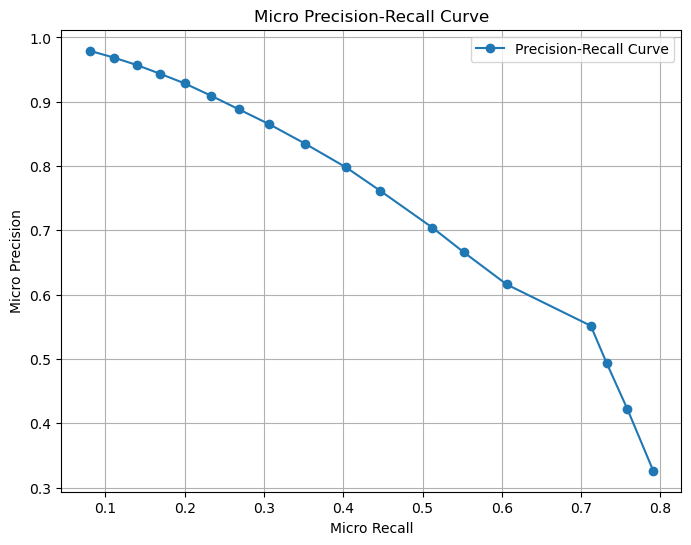

In [9]:
formatted_result_actual = []
formatted_result_pred = []
normalized_factor = 0
for i in range(1, 21):
    normalized_factor += 1/i
    
for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    position = 0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            position += 1
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = 1 / position
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + (1 / position)
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/normalized_factor
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)
calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 4

Best F1 Micro Score: 0.57 (Threshold: 0.85)


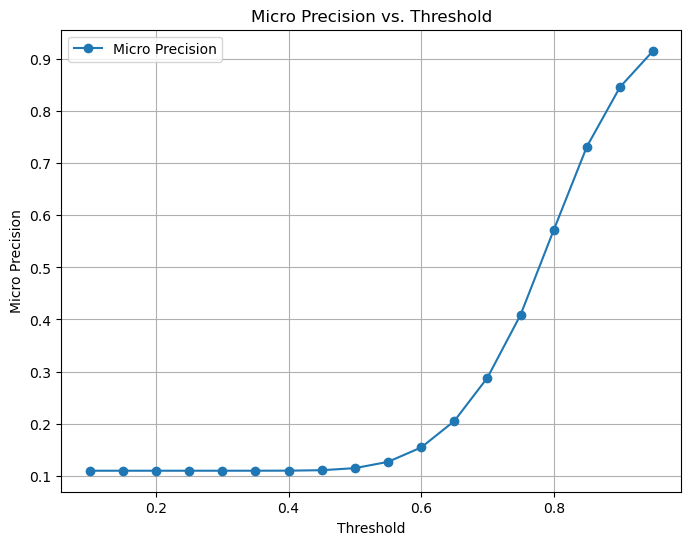

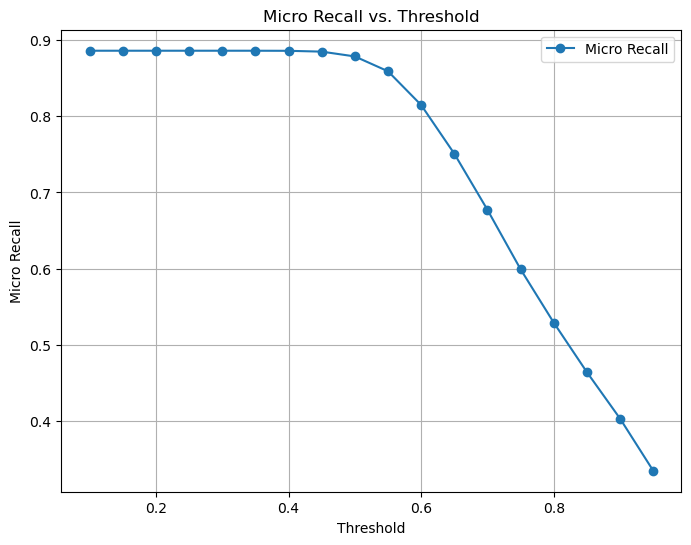

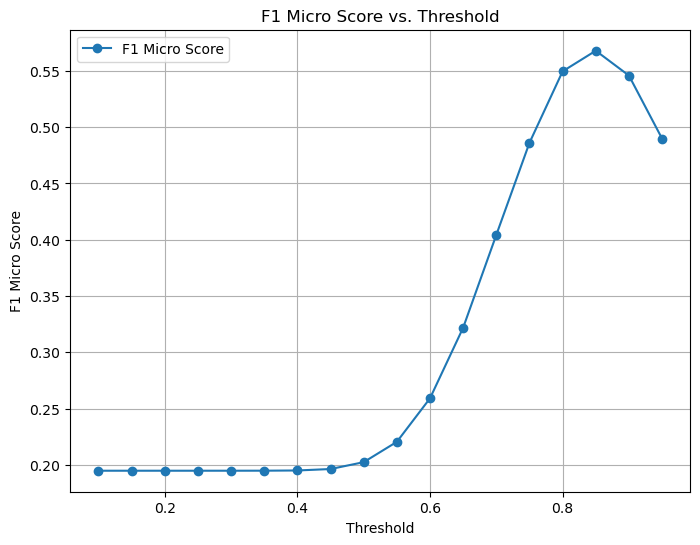

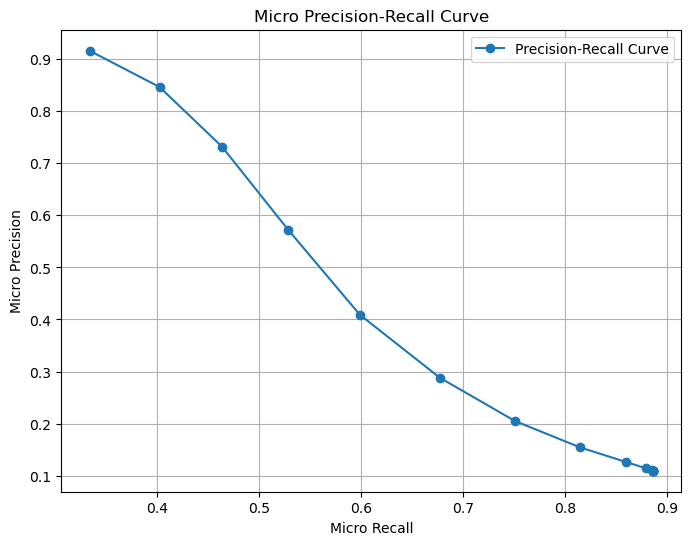

In [10]:
formatted_result_actual = []
formatted_result_pred = []

for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred
                elif cpv_found_and_scores[pred_value] < score_pred:
                    cpv_found_and_scores[pred_value] = score_pred
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        #normalized_score = value/length_number_pred
        single_row_pred[index_cpv] = value
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)
    
calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Evaluation Method 5

Best F1 Micro Score: 0.66 (Threshold: 0.65)


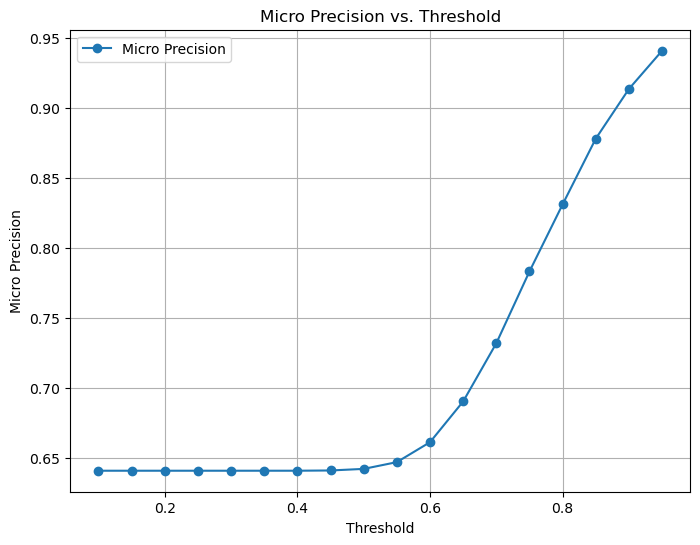

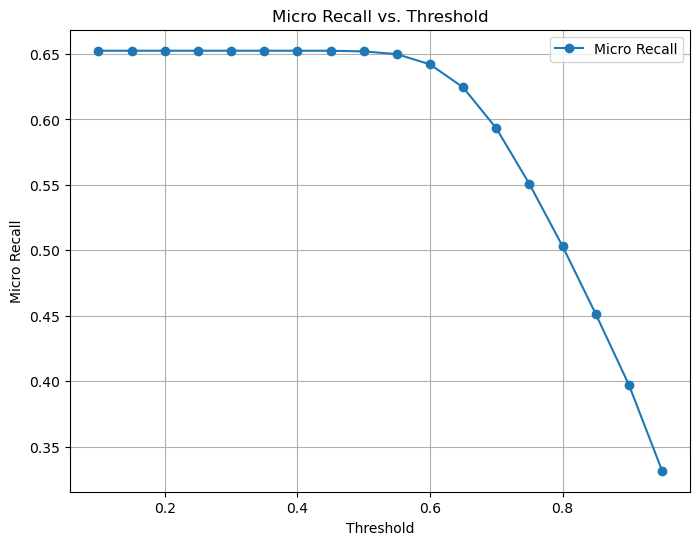

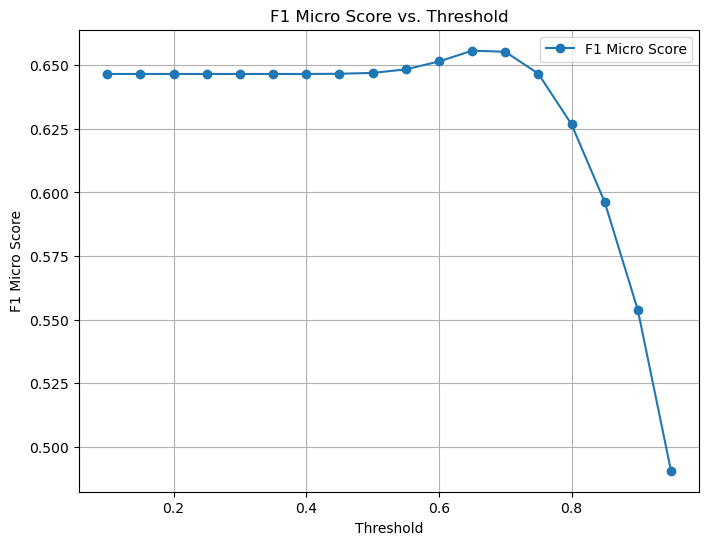

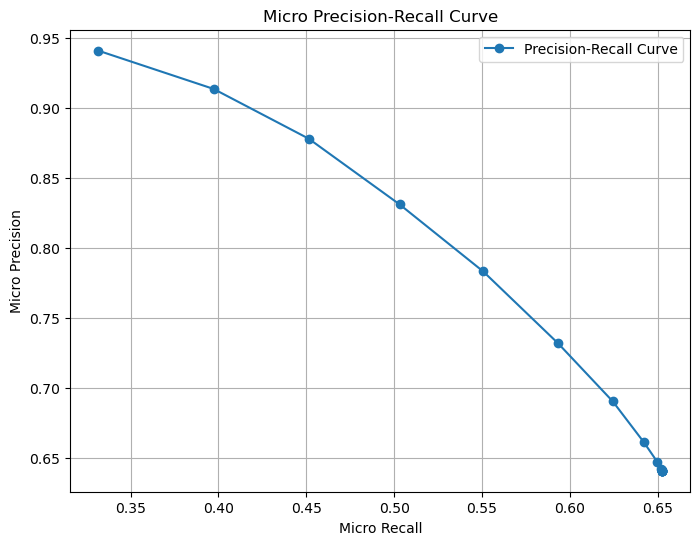

In [11]:
formatted_result_actual = []
formatted_result_pred = []

for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    max_pred = []
    max_score = 0.0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            if score_pred > max_score:
                max_score = score_pred
                max_pred = pred_values
    
    for value in max_pred:
        index_cpv = ALL_REDUCED_CPVS.index(value)
        #normalized_score = value/length_number_pred
        single_row_pred[index_cpv] = max_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)
    
calculate_metrics_and_plot(formatted_result_actual, formatted_result_pred)

## Multi-label report of best method
Best results have been obtained with Method 2, and a threshold of 0.25. Here follows the multi-label report.

In [12]:
formatted_result_actual = []
formatted_result_pred = []
normalized_factor = 0
for i in range(1, 21):
    normalized_factor += 1/i
    
for element in full_predictions:
    single_row_pred = [0.0]*len(ALL_REDUCED_CPVS)
    single_row_actual = [0.0]*len(ALL_REDUCED_CPVS)
    cpv_found_and_scores = {}
    length_number_pred = len(element) - 1
    position = 0
    for single_pred in element:
        if 'actual_cpvs' in single_pred.keys():
            actual_values = single_pred["actual_cpvs"]
            for actual_value in actual_values:
                index_in_all_cpvs = ALL_REDUCED_CPVS.index(actual_value)
                single_row_actual[index_in_all_cpvs] = 1.0
        else:
            position += 1
            pred_values = single_pred["pred"]
            score_pred = single_pred["score"]
            for pred_value in pred_values:
                if not cpv_found_and_scores.get(pred_value):
                    cpv_found_and_scores[pred_value] = score_pred / position
                else:
                    cpv_found_and_scores[pred_value] = cpv_found_and_scores[pred_value] + (score_pred / position)
    for key, value in cpv_found_and_scores.items():
        index_cpv = ALL_REDUCED_CPVS.index(key)
        normalized_score = value/normalized_factor
        single_row_pred[index_cpv] = normalized_score
    formatted_result_actual.append(single_row_actual)
    formatted_result_pred.append(single_row_pred)

In [13]:
from sklearn import metrics

threshold = 0.25
binary_predictions = (np.array(formatted_result_pred) >= threshold).astype(int)
print(metrics.classification_report(formatted_result_actual, binary_predictions, target_names=ALL_REDUCED_CPVS))

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       79810       0.57      0.63      0.60       211
       42999       0.86      0.67      0.75         9
       43252       0.75      0.43      0.55         7
       31173       0.00      0.00      0.00         0
       15431       0.67      0.44      0.53         9
       31527       0.59      0.56      0.57        89
       76320       1.00      0.29      0.44         7
       50230       0.73      0.79      0.76       285
       19000       0.64      0.52      0.57       277
       43311       0.00      0.00      0.00         2
       33620       0.71      0.78      0.74        67
       66122       0.55      0.43      0.48        54
       76110       0.67      0.67      0.67         3
       44172       0.00      0.00      0.00         7
       14760       0.00      0.00      0.00         0
       34327       1.00      0.50      0.67         2
       63730       0.78      0.56      0.65        55
       37540       1.00    

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
import pandas as pd
report = metrics.classification_report(formatted_result_actual, binary_predictions, target_names=ALL_REDUCED_CPVS, output_dict=True)
df = pd.DataFrame(report).transpose()
df.head()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

precision    recall  f1-score  support
79810   0.565957  0.630332  0.596413    211.0
42999   0.857143  0.666667  0.750000      9.0
43252   0.750000  0.428571  0.545455      7.0
31173   0.000000  0.000000  0.000000      0.0
15431   0.666667  0.444444  0.533333      9.0

In [16]:
df.to_csv("classification_report_5_digits.csv")